# 0. Setup

In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
import importlib, inspect
from src.data.loader import load_raw, reindex_daily
from src.data.validation import validate_raw, print_validation_report
from src.data.preprocess import preprocess_all_customers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [63]:
df = load_raw("data/raw/train set.csv")       # strict load
rep, ok = validate_raw(df)                # build report
print_validation_report(rep, ok)          # pretty print

# (optional) daily index for EDA-only visuals
df_daily = reindex_daily(df)

      CUSTOMER  rows      start        end  duplicates_same_date  nan_qty  negative_qty  nonfinite_qty  noninteger_qty  missing_days  max_gap_days
       ARGALYS   830 2019-08-01 2023-06-02                     0        0             0              0               0           572            22
LES MIRACULEUX   950 2019-05-10 2023-06-02                     0        0             0              0               0           535           208
  MINCI DELICE  1531 2017-09-30 2023-06-02                     0        0             0              0               0           541             4
    NUTRAVANCE  2014 2015-08-26 2023-06-02                     0        0             0              0               0           824            13
        GLOBAL  5325 2015-08-26 2023-06-02                     0        0             0              0               0          2472           208

Validation: PASS


In [5]:
print(df.head(3))
print(df_daily.head(3))
df_daily.info()

        DATE CUSTOMER  QUANTITY
0 2019-08-01  ARGALYS       6.0
1 2019-08-14  ARGALYS       1.0
2 2019-09-05  ARGALYS       4.0
        DATE CUSTOMER  QUANTITY
0 2019-08-01  ARGALYS       6.0
1 2019-08-02  ARGALYS       NaN
2 2019-08-03  ARGALYS       NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7797 entries, 0 to 7796
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DATE      7797 non-null   datetime64[ns]
 1   CUSTOMER  7797 non-null   object        
 2   QUANTITY  5325 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 182.9+ KB


In [96]:
df_clean, summary = preprocess_all_customers(
    df,
    long_gap_days=30,
    min_nonzero_run=5,
    min_nonzero_value=1.0,
    gap_limit=7,
    causal=False,
    verbose=True,
)

print("Cleaned dataset shape:", df_clean.shape)
print(summary[["CUSTOMER", "inactive_lead_days", "clean_start", "clean_end"]])

[clean_and_truncate_series] {'active': True, 'orig_len': 1402, 'clean_len': 1030, 'active_days': 1030, 'orig_start': Timestamp('2019-08-01 00:00:00'), 'orig_end': Timestamp('2023-06-02 00:00:00'), 'clean_start': Timestamp('2020-07-27 00:00:00'), 'clean_end': Timestamp('2023-05-22 00:00:00'), 'inactive_lead_days': 361, 'inactive_tail_days': 11, 'gap_limit': 7, 'causal': False, 'min_nonzero_run': 5, 'min_nonzero_value': 1.0}
[clean_and_truncate_series] {'active': True, 'orig_len': 1485, 'clean_len': 1261, 'active_days': 1261, 'orig_start': Timestamp('2019-05-10 00:00:00'), 'orig_end': Timestamp('2023-06-02 00:00:00'), 'clean_start': Timestamp('2019-12-09 00:00:00'), 'clean_end': Timestamp('2023-05-22 00:00:00'), 'inactive_lead_days': 213, 'inactive_tail_days': 11, 'gap_limit': 7, 'causal': False, 'min_nonzero_run': 5, 'min_nonzero_value': 1.0}
[clean_and_truncate_series] {'active': True, 'orig_len': 2072, 'clean_len': 2072, 'active_days': 2072, 'orig_start': Timestamp('2017-09-30 00:00:0

In [116]:
cust_list = df_clean["CUSTOMER"].unique()

for cust in cust_list:
    df_stat = df_clean.loc[df_clean["CUSTOMER"] == cust].describe()
    print(f"\n{'='*40}\nStats for {cust}:\n{'='*40}")
    print(df_stat)


Stats for ARGALYS:
                      DATE     QUANTITY
count                 1030  1030.000000
mean   2021-12-23 12:00:00    29.803398
min    2020-07-27 00:00:00     1.000000
25%    2021-04-10 06:00:00    14.000000
50%    2021-12-23 12:00:00    24.666667
75%    2022-09-06 18:00:00    39.000000
max    2023-05-22 00:00:00   215.000000
std                    NaN    23.754207

Stats for LES MIRACULEUX:
                      DATE     QUANTITY
count                 1261  1261.000000
mean   2021-08-30 00:00:00   740.214909
min    2019-12-09 00:00:00     3.000000
25%    2020-10-19 00:00:00   226.000000
50%    2021-08-30 00:00:00   554.000000
75%    2022-07-11 00:00:00  1086.000000
max    2023-05-22 00:00:00  4949.000000
std                    NaN   664.858880

Stats for MINCI DELICE:
                      DATE     QUANTITY
count                 2072  2072.000000
mean   2020-07-31 12:00:00  1951.875724
min    2017-09-30 00:00:00    66.000000
25%    2019-03-01 18:00:00  1274.916667
50%    2

In [122]:
df_clean.to_csv("data/processed/cleaned_data.csv", index=False)

# Per Customer Time Series with 7 day MA

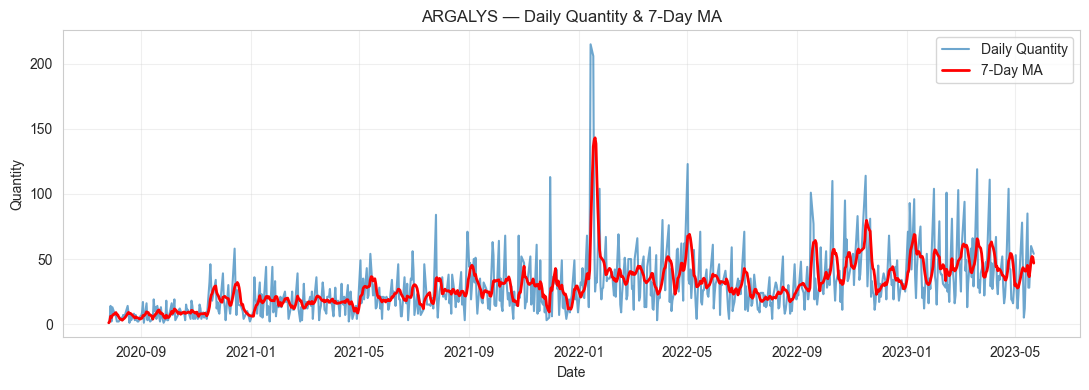

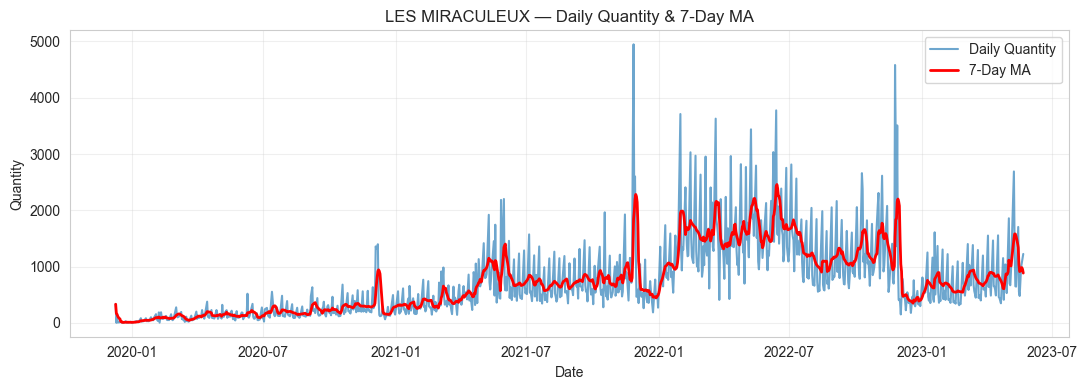

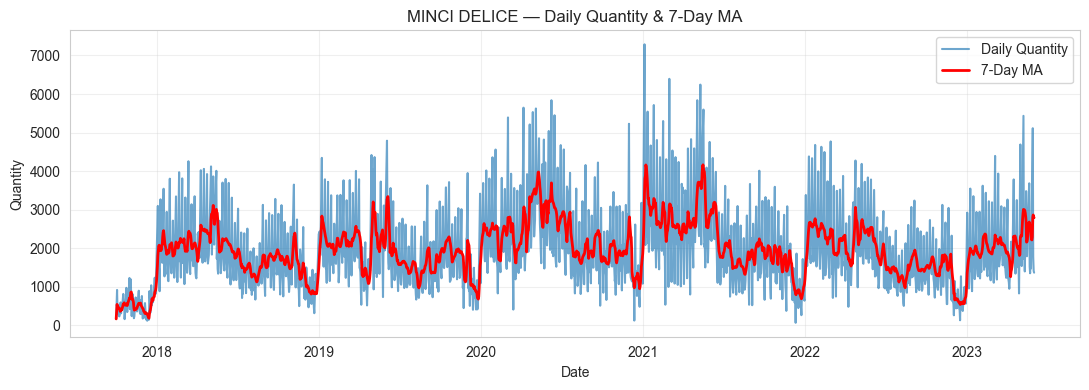

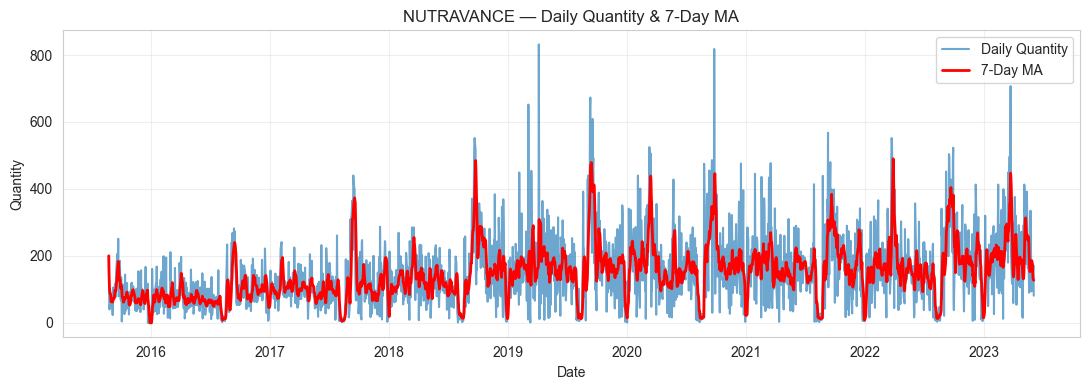

In [97]:
for cust, g in df_clean.groupby("CUSTOMER"):
    g = g.set_index("DATE").asfreq("D")
    g["7D_MA"] = g["QUANTITY"].rolling(7, min_periods=1).mean()

    plt.figure(figsize=(11,4))
    plt.plot(g.index, g["QUANTITY"], alpha=0.65, label="Daily Quantity")
    plt.plot(g.index, g["7D_MA"], linewidth=2, color= 'red', label="7-Day MA")
    plt.title(f"{cust} — Daily Quantity & 7-Day MA")
    plt.xlabel("Date")
    plt.ylabel("Quantity")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"outputs/figures/eda/{cust}_timeseries.png", dpi=150)

# Seasonal Plots

In [98]:
sns.set_style("whitegrid")

In [99]:
def add_calendar_columns(df):
    df["Month"] = df["DATE"].dt.month
    df["DayOfWeek"] = df["DATE"].dt.dayofweek  # 0=Mon,6=Sun
    df["DayOfMonth"] = df["DATE"].dt.day
    return df

df_season = add_calendar_columns(df_clean.copy())

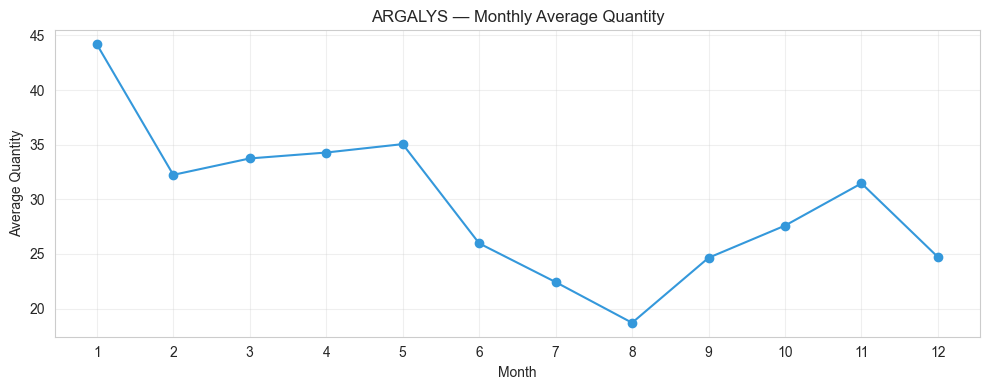

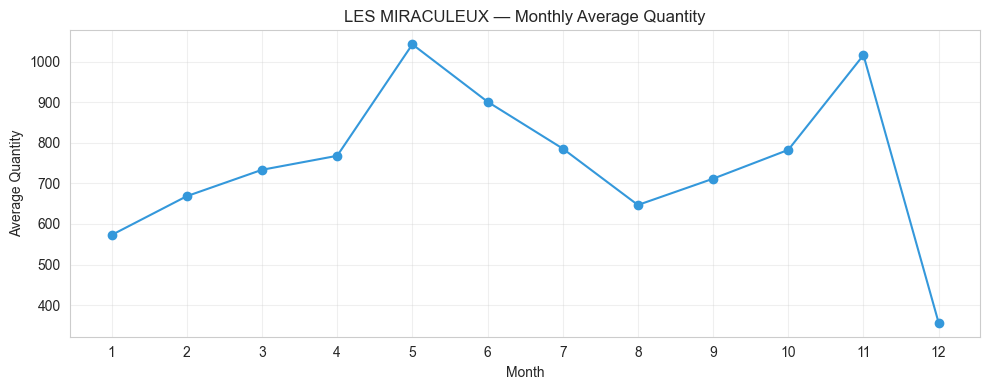

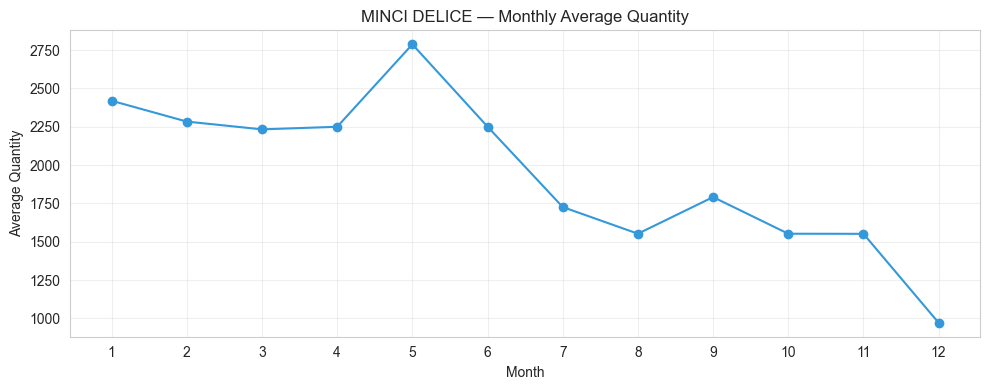

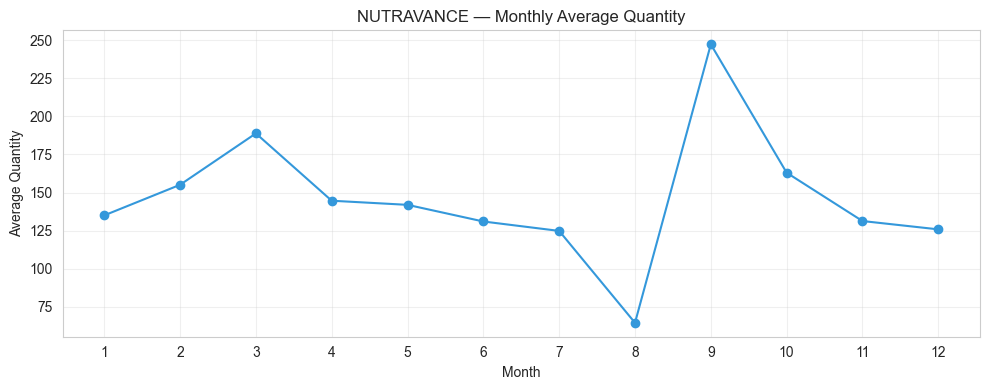

In [100]:
for cust, g in df_season.groupby("CUSTOMER"):
    plt.figure(figsize=(10,4))
    monthly = g.groupby("Month")["QUANTITY"].mean()
    plt.plot(monthly.index, monthly.values, marker='o', color="#3498DB")
    plt.title(f"{cust} — Monthly Average Quantity")
    plt.xlabel("Month")
    plt.ylabel("Average Quantity")
    plt.xticks(range(1,13))
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"outputs/figures/eda/{cust}_seasonal_monthly.png", dpi=150)

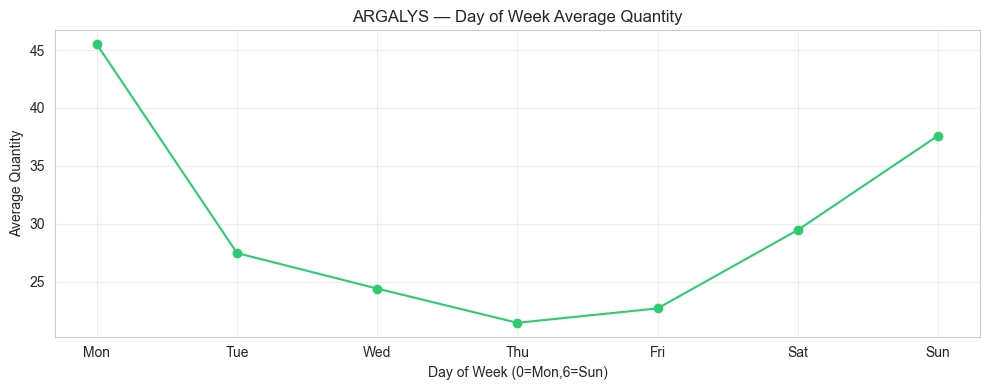

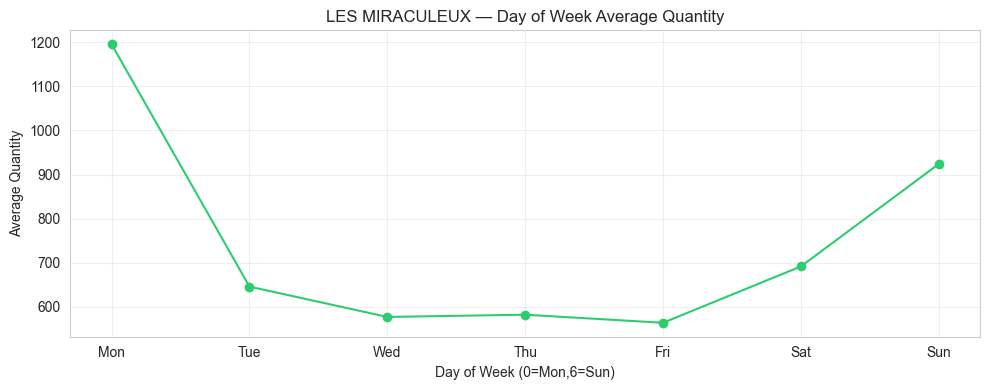

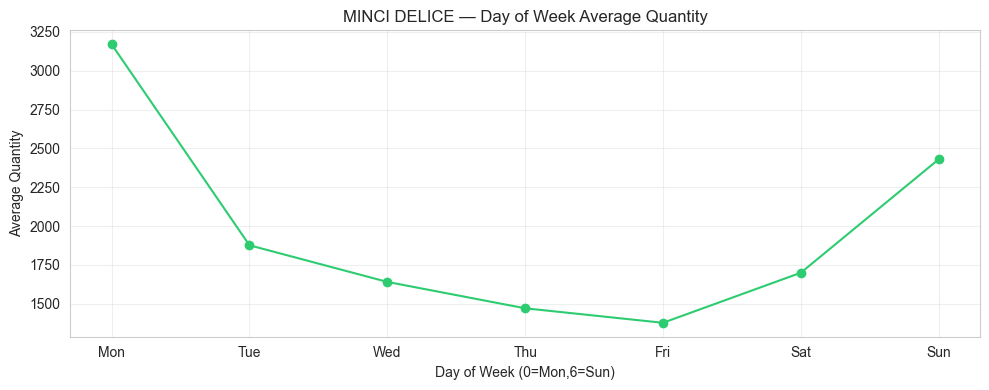

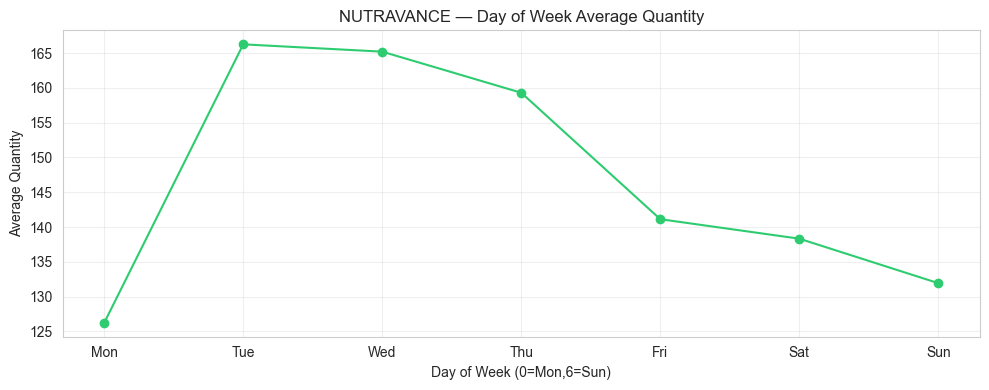

In [101]:
for cust, g in df_season.groupby("CUSTOMER"):
    plt.figure(figsize=(10,4))
    dow = g.groupby("DayOfWeek")["QUANTITY"].mean()
    plt.plot(dow.index, dow.values, marker='o', color="#2ECC71")
    plt.title(f"{cust} — Day of Week Average Quantity")
    plt.xlabel("Day of Week (0=Mon,6=Sun)")
    plt.ylabel("Average Quantity")
    plt.xticks(range(7), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"outputs/figures/eda/{cust}_seasonal_dow.png", dpi=150)

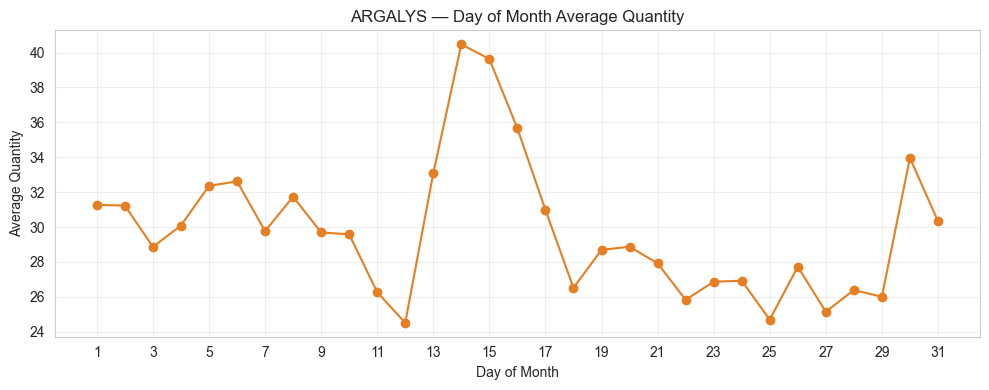

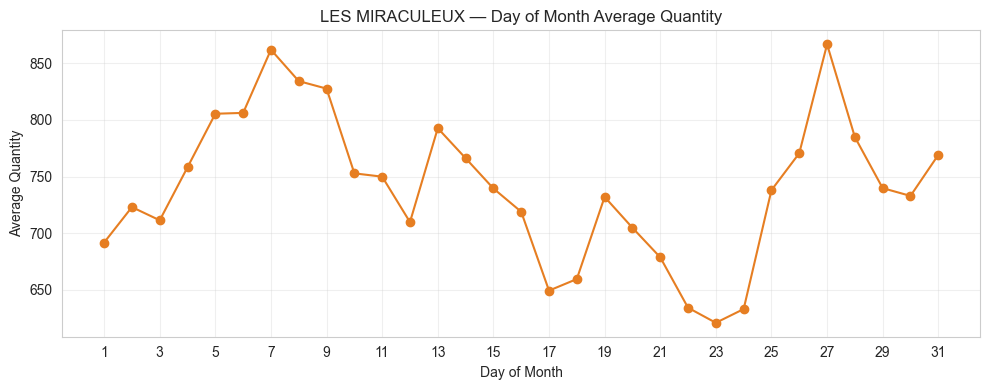

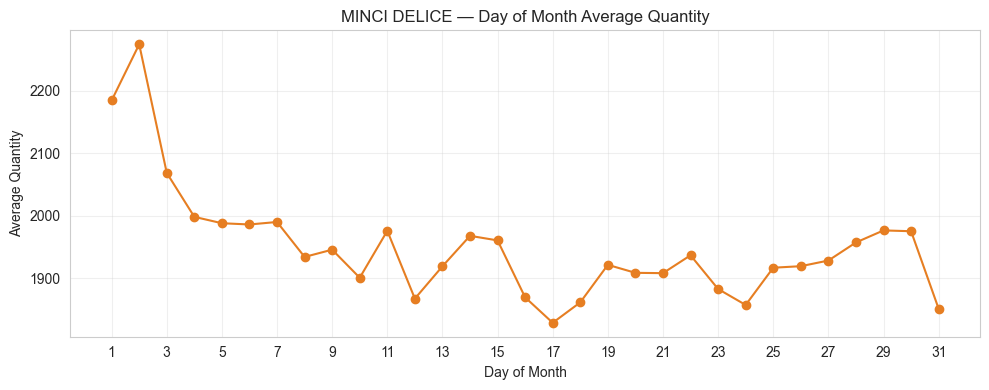

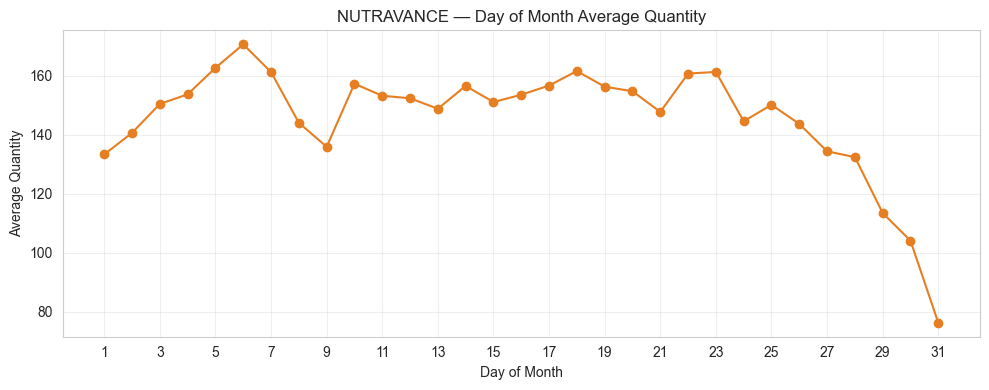

In [102]:
for cust, g in df_season.groupby("CUSTOMER"):
    plt.figure(figsize=(10,4))
    dom = g.groupby("DayOfMonth")["QUANTITY"].mean()
    plt.plot(dom.index, dom.values, marker='o', color="#E67E22")
    plt.title(f"{cust} — Day of Month Average Quantity")
    plt.xlabel("Day of Month")
    plt.ylabel("Average Quantity")
    plt.xticks(range(1,32,2))
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"outputs/figures/eda/{cust}_seasonal_dom.png", dpi=150)

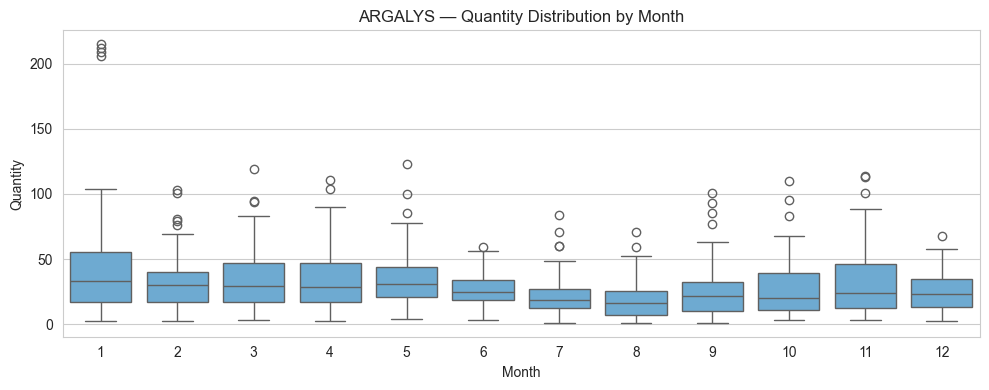

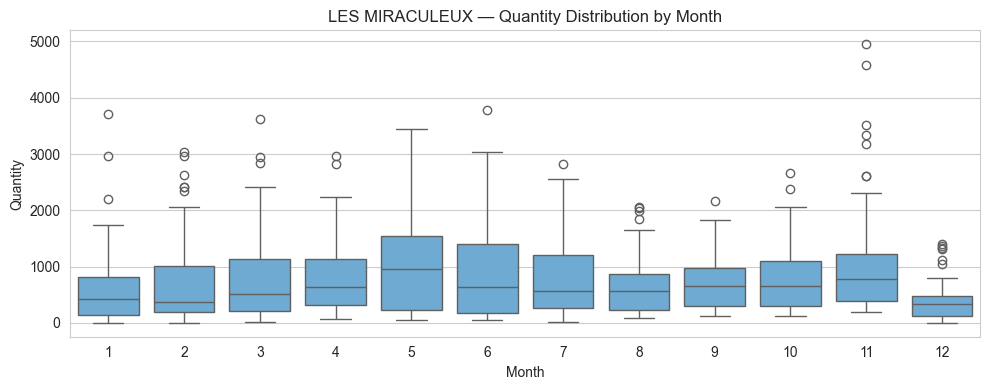

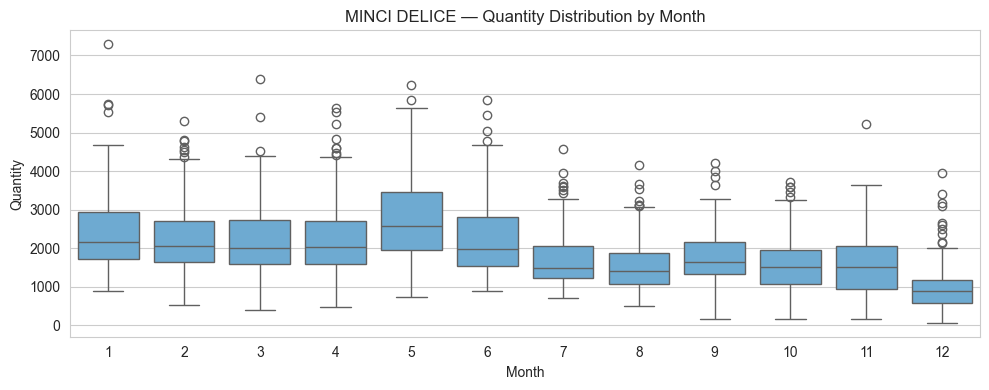

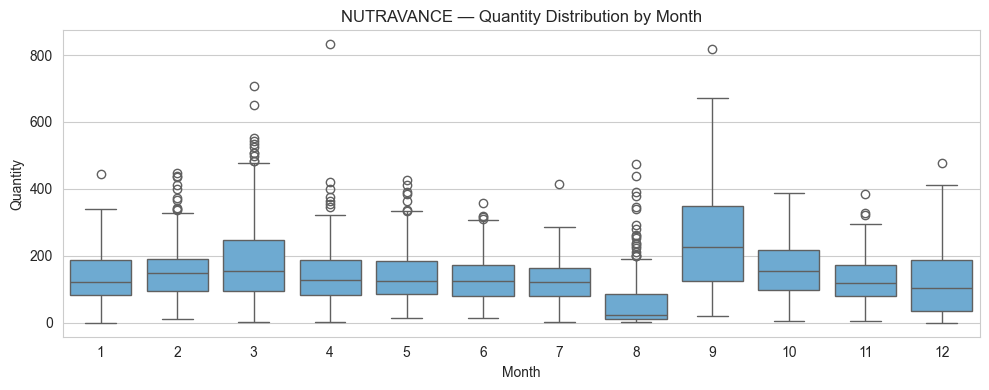

In [103]:
for cust, g in df_season.groupby("CUSTOMER"):
    plt.figure(figsize=(10,4))
    sns.boxplot(data=g, x="Month", y="QUANTITY", color="#5DADE2")
    plt.title(f"{cust} — Quantity Distribution by Month")
    plt.xlabel("Month")
    plt.ylabel("Quantity")
    plt.tight_layout()
    plt.savefig(f"outputs/figures/eda/{cust}_box_month.png", dpi=150)

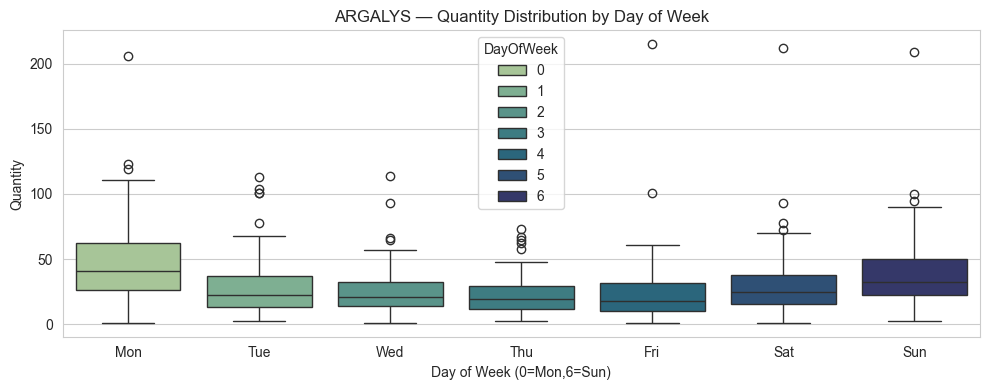

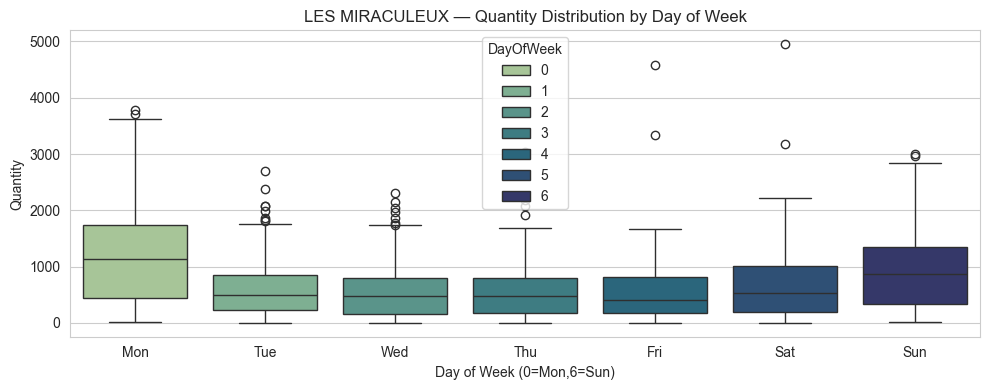

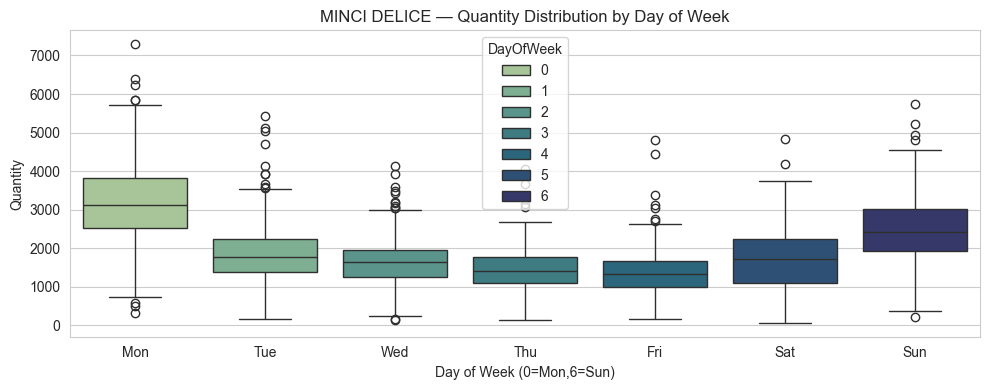

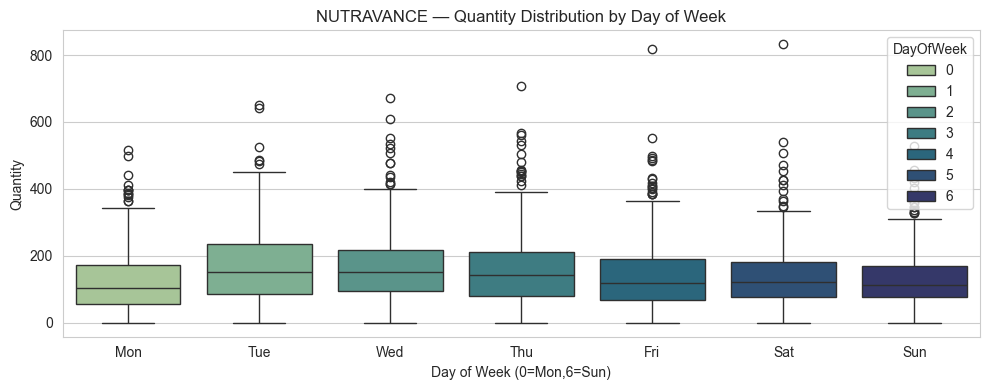

In [104]:
for cust, g in df_season.groupby("CUSTOMER"):
    plt.figure(figsize=(10,4))
    sns.boxplot(data=g, x="DayOfWeek", y="QUANTITY", palette="crest", hue = "DayOfWeek", )
    plt.title(f"{cust} — Quantity Distribution by Day of Week")
    plt.xlabel("Day of Week (0=Mon,6=Sun)")
    plt.ylabel("Quantity")
    plt.xticks(range(7), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
    plt.tight_layout()
    plt.savefig(f"outputs/figures/eda/{cust}_box_dow.png", dpi=150)

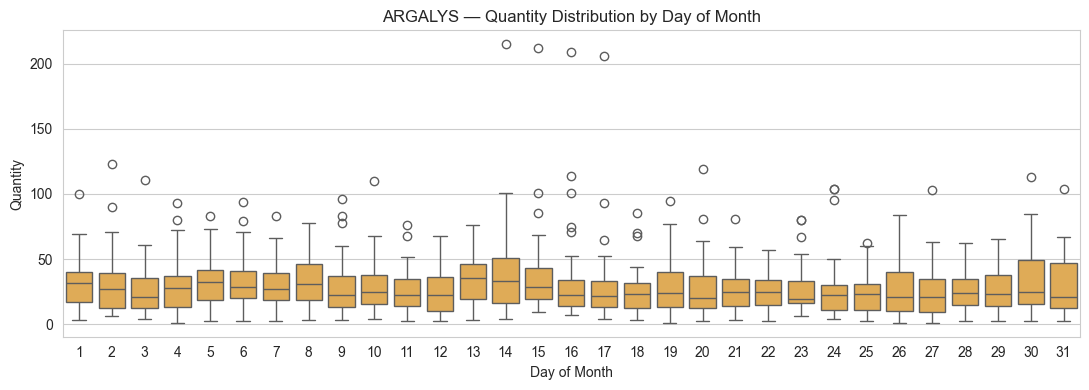

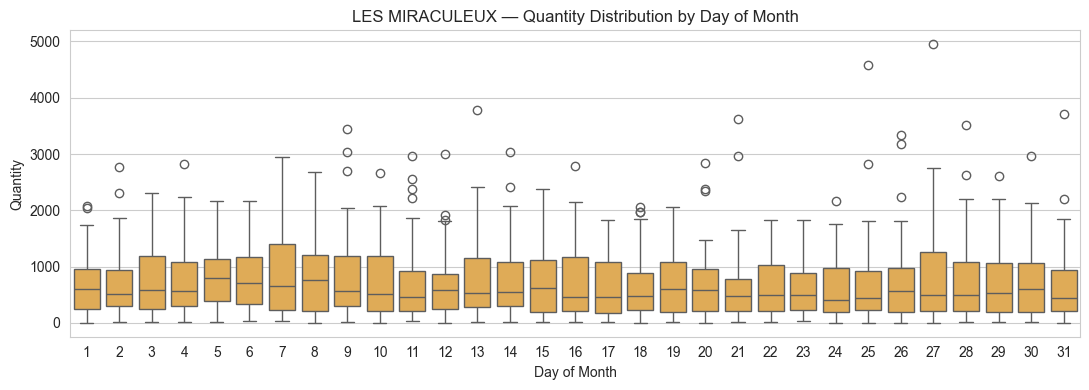

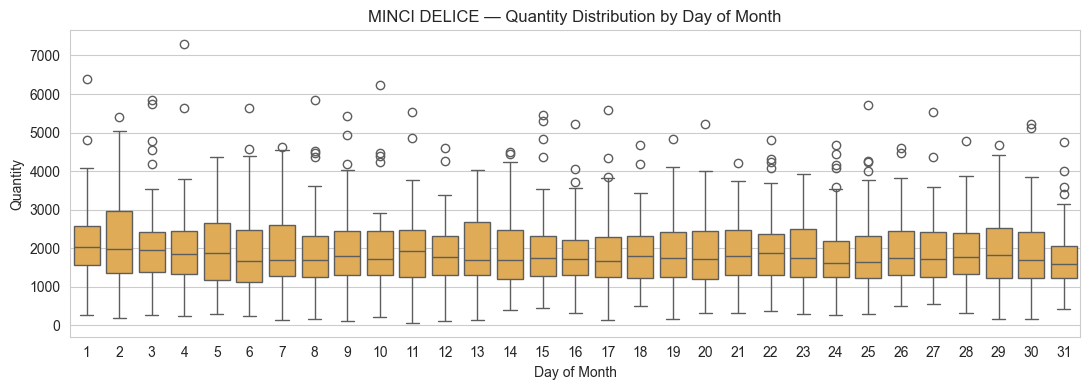

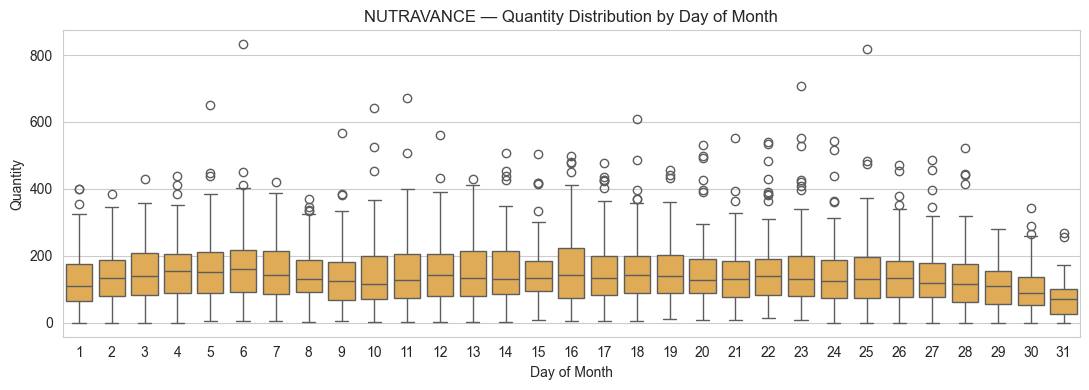

In [105]:
for cust, g in df_season.groupby("CUSTOMER"):
    plt.figure(figsize=(11,4))
    sns.boxplot(data=g, x="DayOfMonth", y="QUANTITY", color="#F5B041")
    plt.title(f"{cust} — Quantity Distribution by Day of Month")
    plt.xlabel("Day of Month")
    plt.ylabel("Quantity")
    plt.tight_layout()
    plt.savefig(f"outputs/figures/eda/{cust}_box_dom.png", dpi=150)

# STL Decomposition

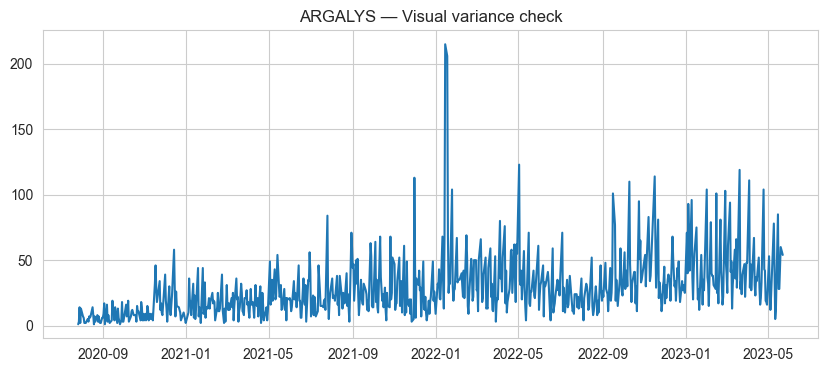

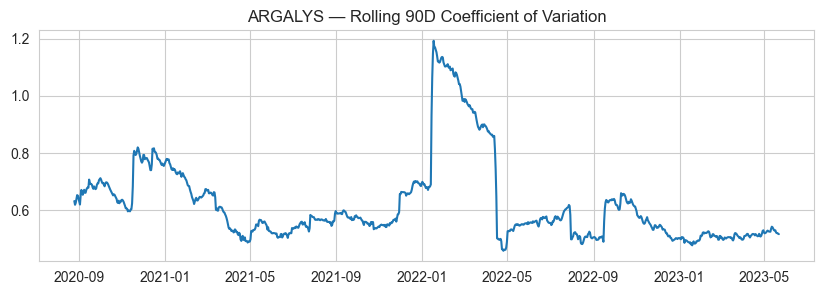

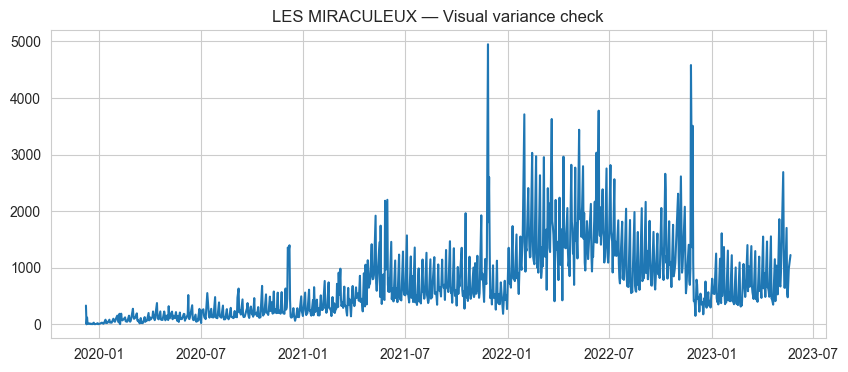

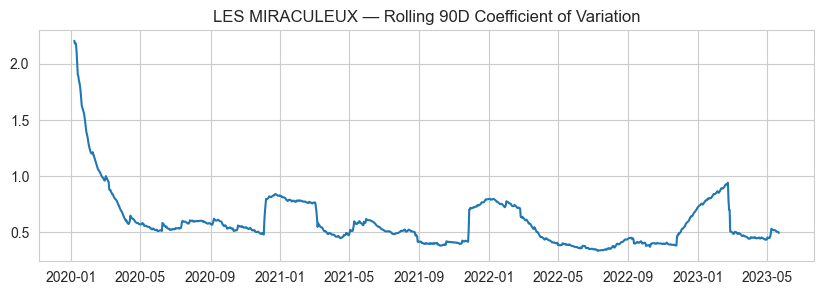

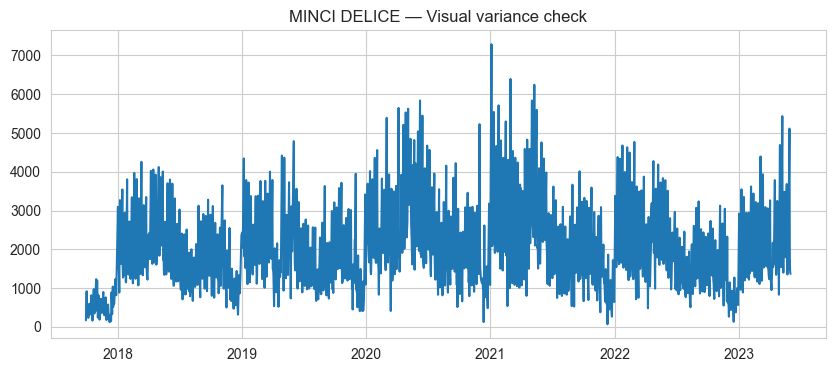

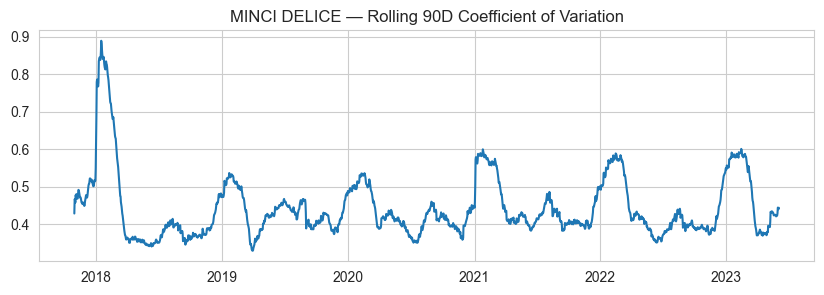

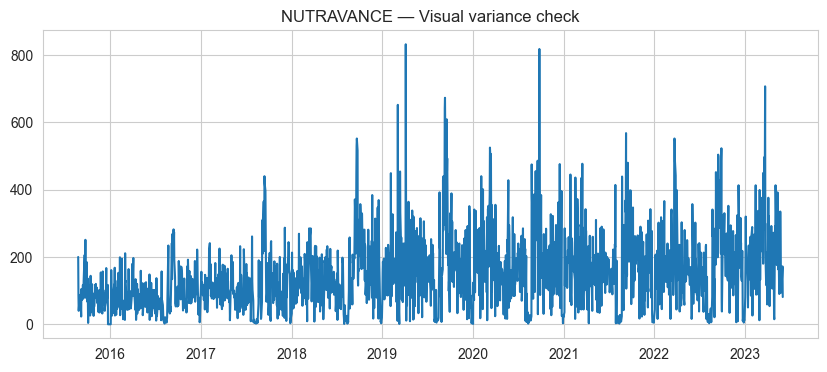

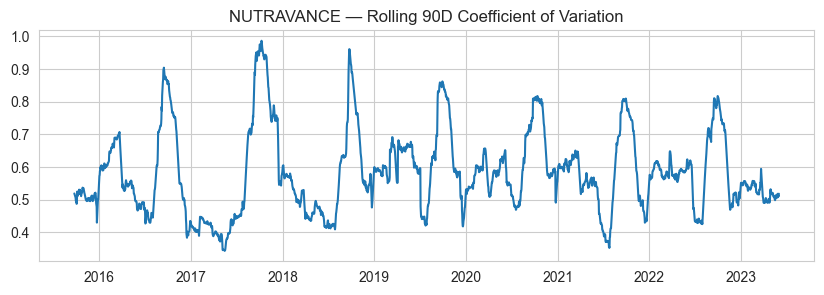

In [106]:
for cust, g in df_clean.groupby("CUSTOMER"):
    s = g.set_index("DATE").asfreq("D")["QUANTITY"].fillna(0)
    
    # visualize seasonality amplitude change
    plt.figure(figsize=(10,4))
    plt.plot(s)
    plt.title(f"{cust} — Visual variance check")
    plt.show()

    # quick rule of thumb: coefficient of variation over rolling windows
    roll_cv = s.rolling(90, min_periods=30).std() / s.rolling(90, min_periods=30).mean()
    plt.figure(figsize=(10,3))
    plt.plot(roll_cv)
    plt.title(f"{cust} — Rolling 90D Coefficient of Variation")
    plt.show()

ARGALYS → RelResid(Additive)=0.2171, RelResid(Multiplicative/log)=0.2746 → Best: additive
LES MIRACULEUX → RelResid(Additive)=0.3378, RelResid(Multiplicative/log)=0.2035 → Best: multiplicative (log)
MINCI DELICE → RelResid(Additive)=0.5458, RelResid(Multiplicative/log)=0.3928 → Best: multiplicative (log)
NUTRAVANCE → RelResid(Additive)=0.4950, RelResid(Multiplicative/log)=0.4153 → Best: multiplicative (log)


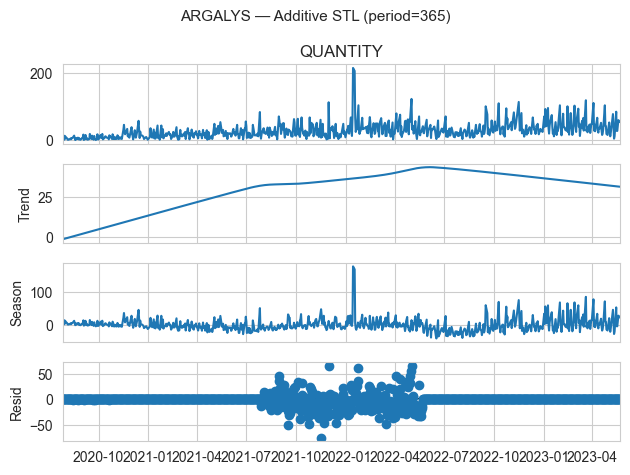

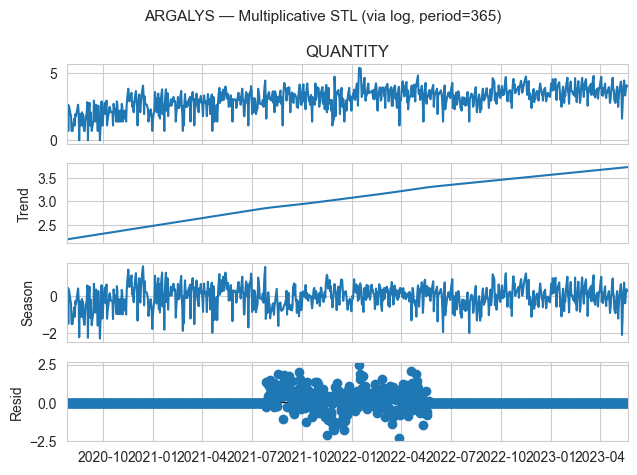

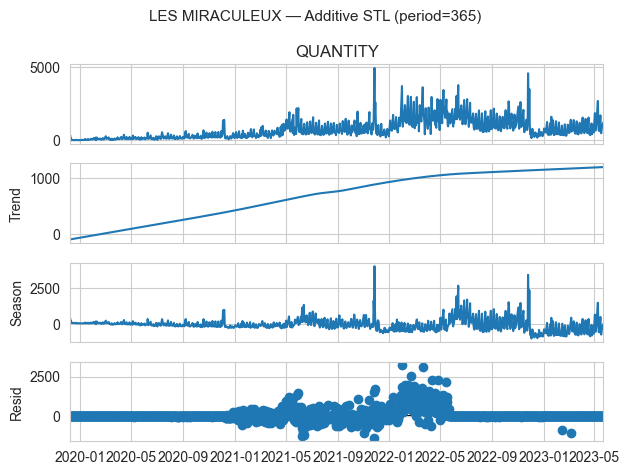

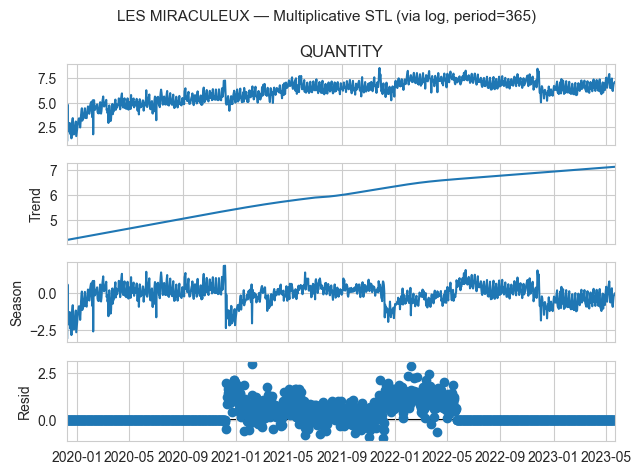

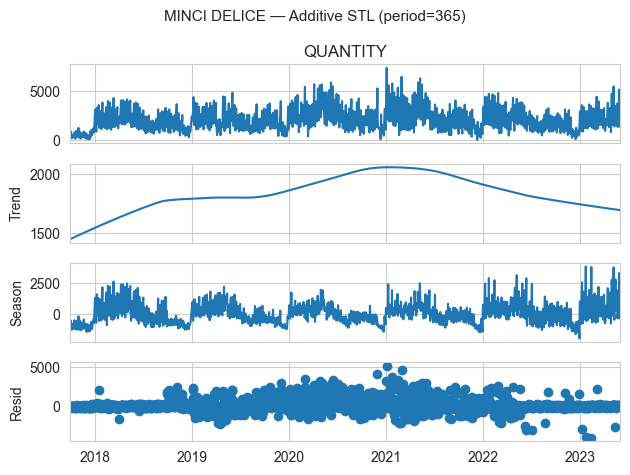

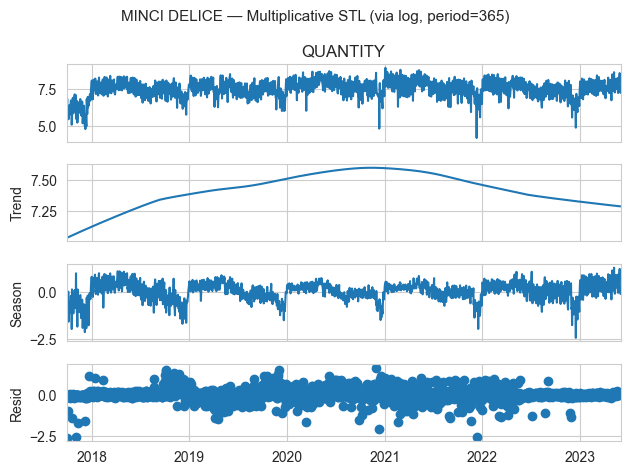

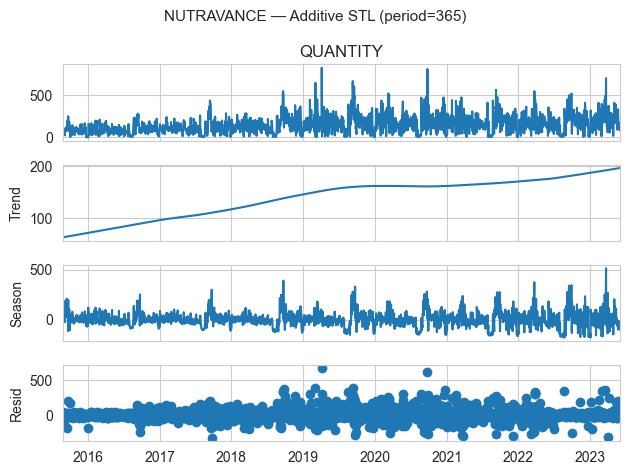

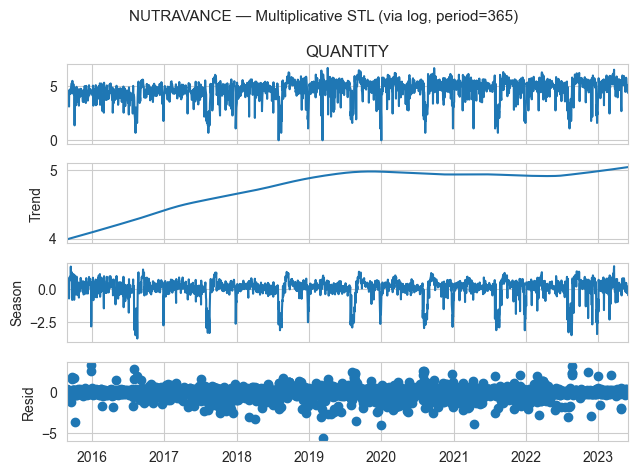

In [108]:
results = []

for cust, g in df_clean.groupby("CUSTOMER"):
    # 1) Build daily series
    s = g.set_index("DATE").asfreq("D")["QUANTITY"]

    # 2) Prepare series for decomposition
    #    - interpolate for gaps (keeps shape similar for fair comparison)
    s_add = s.interpolate(method="time", limit_direction="both")
    # multiplicative: log requires strictly positive values
    s_pos = s.replace(0, np.nan)
    s_mul = s_pos.interpolate(method="time", limit_direction="both")

    # If too short or all NaNs, skip cleanly
    if s_add.dropna().shape[0] < 14:  # arbitrary minimum length
        print(f"Skipping {cust}: not enough data after interpolation.")
        continue

    # 3) Additive STL (original scale)
    res_add = STL(s_add.fillna(0), period=365, robust=True).fit()
    fig_add = res_add.plot()
    fig_add.suptitle(f"{cust} — Additive STL (period=365)", fontsize=11)
    fig_add.tight_layout()

    # 4) Multiplicative STL (log scale)
    # If still any non-positive after interpolation, nudge a tiny epsilon
    s_mul = s_mul.copy()
    if (s_mul <= 0).any():
        s_mul = s_mul.mask(s_mul <= 0, np.nan).interpolate(method="time", limit_direction="both")
        # final fallback (very rare): add tiny epsilon
        s_mul = s_mul.fillna(s_mul.median()).clip(lower=1e-6)

    s_log = np.log(s_mul)
    res_mul = STL(s_log, period=365, robust=True).fit()
    fig_mul = res_mul.plot()
    fig_mul.suptitle(f"{cust} — Multiplicative STL (via log, period=365)", fontsize=11)
    fig_mul.tight_layout()

    # 5) Residual variance comparison
    #    - Additive: variance on original scale
    #    - Multiplicative: variance on log scale (natural for multiplicative)
    var_y_add = np.nanvar(s_add)
    var_res_add = np.nanvar(res_add.resid)
    rel_add = var_res_add / var_y_add if var_y_add > 0 else np.nan

    var_y_log = np.nanvar(s_log)
    var_res_mul = np.nanvar(res_mul.resid)
    rel_mul = var_res_mul / var_y_log if var_y_log > 0 else np.nan

    better = "multiplicative (log)" if (np.nan_to_num(rel_mul, nan=np.inf) < np.nan_to_num(rel_add, nan=np.inf)) else "additive"

    results.append({
        "Customer": cust,
        "VarResid_Add": float(var_res_add),
        "VarY_Add": float(var_y_add),
        "RelResid_Add": float(rel_add),
        "VarResid_MulLog": float(var_res_mul),
        "VarY_Log": float(var_y_log),
        "RelResid_MulLog": float(rel_mul),
        "Better_Decomposition": better
    })

    print(
        f"{cust} → "
        f"RelResid(Additive)={rel_add:.4f}, "
        f"RelResid(Multiplicative/log)={rel_mul:.4f} → Best: {better}"
    )

In [109]:
# 6) Save comparison table
comp_df = pd.DataFrame(results).sort_values("Customer")
comp_df

,Customer,VarResid_Add,VarY_Add,RelResid_Add,VarResid_MulLog,VarY_Log,RelResid_MulLog,Better_Decomposition
0,ARGALYS,122.403514,563.714538,0.217137,0.197920,0.720634,0.274647,additive
1,LES MIRACULEUX,149217.896536,441686.785848,0.337836,0.275112,1.352088,0.203472,multiplicative (log)
2,MINCI DELICE,544405.871585,997434.803115,0.545806,0.128927,0.328261,0.392757,multiplicative (log)
3,NUTRAVANCE,5122.671078,10348.267588,0.495027,0.340046,0.818709,0.415344,multiplicative (log)


In [110]:
def demand_type(adi, cv):
    # Syntetos & Boylan quadrants
    if pd.isna(adi) or pd.isna(cv):
        return "Unknown"
    if adi <= 1.32 and cv <= 0.49: return "Smooth"
    if adi <= 1.32 and cv >  0.49: return "Erratic"
    if adi >  1.32 and cv <= 0.49: return "Intermittent"
    return "Lumpy"

rows = []
for cust, g in df_clean.groupby("CUSTOMER"):
    s = g.set_index("DATE").asfreq("D")["QUANTITY"].fillna(0)
    mean = s.mean(); std = s.std()
    cv = std/mean if mean else np.nan
    zero_pct = (s==0).mean()*100
    nz_idx = s.index[s>0]
    adi = np.mean(np.diff(nz_idx.values.astype("datetime64[D]")).astype(int)) if len(nz_idx)>1 else np.nan
    rows.append([cust, mean, std, cv, zero_pct, adi, demand_type(adi, cv)])

eda_df = pd.DataFrame(rows, columns=["Customer","Mean","Std","CV","Zero%","ADI","DemandType"])
display(eda_df)

,Customer,Mean,Std,CV,Zero%,ADI,DemandType
0,ARGALYS,29.803398,23.754207,0.797030,0.000000,1.000000,Erratic
1,LES MIRACULEUX,740.214909,664.858880,0.898197,0.000000,1.000000,Erratic
2,MINCI DELICE,1951.875724,998.957668,0.511794,0.000000,1.000000,Erratic
3,NUTRAVANCE,146.924242,101.744362,0.692495,0.422833,1.004248,Erratic


In [117]:
print(eda_df)

         Customer         Mean         Std        CV     Zero%       ADI  \
0         ARGALYS    29.803398   23.754207  0.797030  0.000000  1.000000   
1  LES MIRACULEUX   740.214909  664.858880  0.898197  0.000000  1.000000   
2    MINCI DELICE  1951.875724  998.957668  0.511794  0.000000  1.000000   
3      NUTRAVANCE   146.924242  101.744362  0.692495  0.422833  1.004248   

  DemandType  
0    Erratic  
1    Erratic  
2    Erratic  
3    Erratic  


/var/folders/hy/9zm9m1bj36vcmmw7gr4b2m340000gn/T/ipykernel_43970/463251407.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.grid(alpha=0.3); plt.tight_layout()


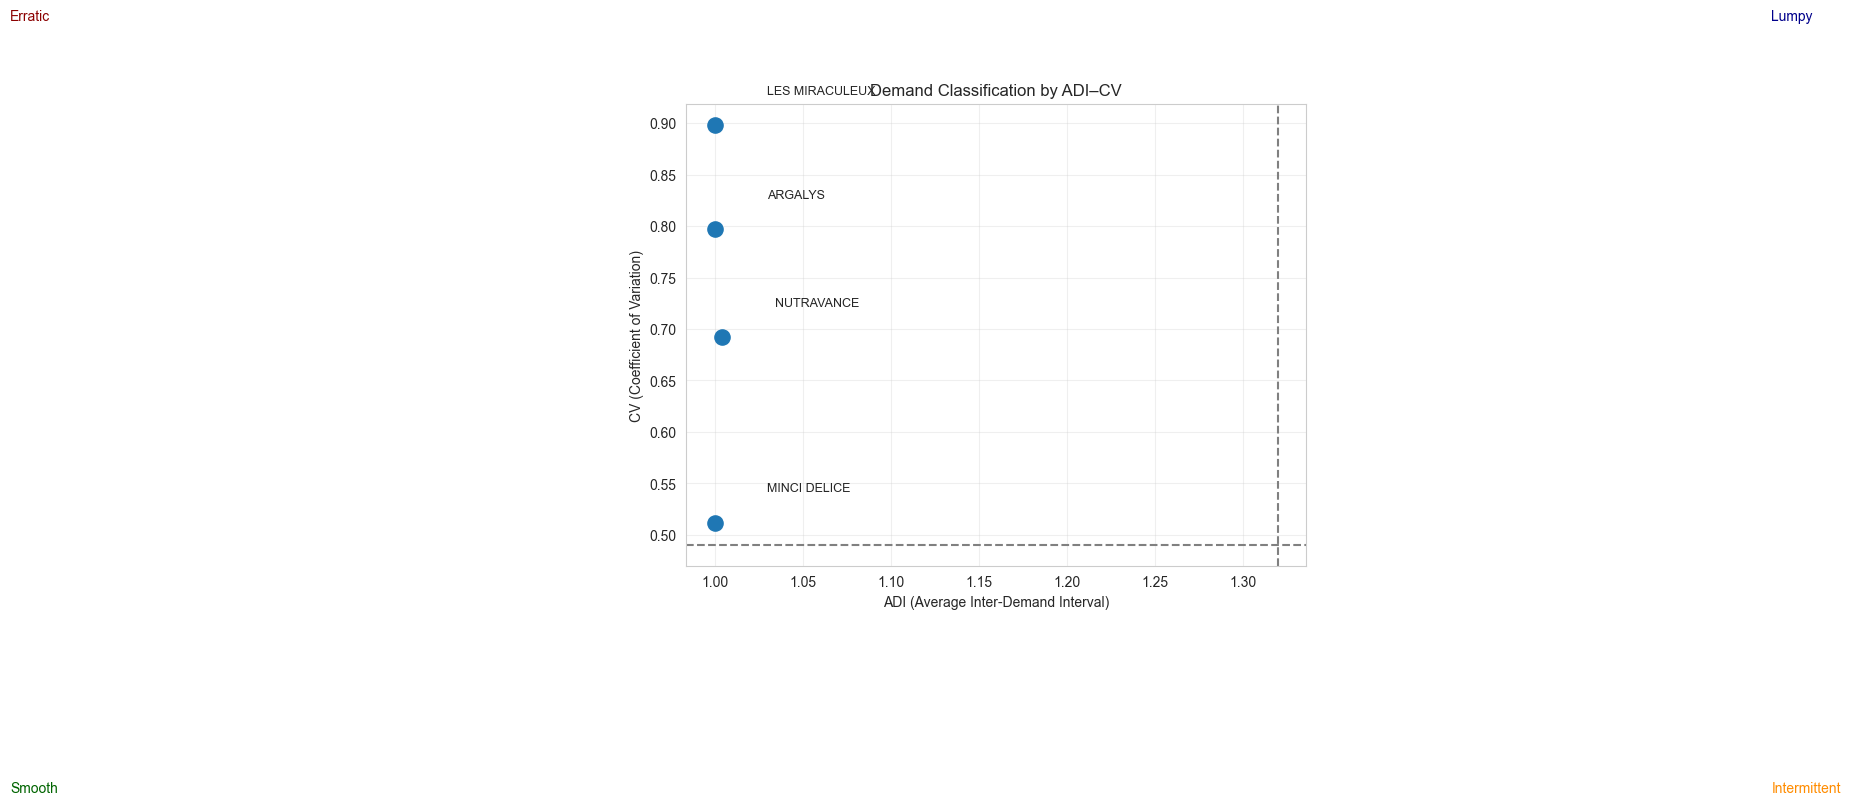

In [111]:
plt.figure(figsize=(8,6))
plt.scatter(eda_df["ADI"], eda_df["CV"], s=120)

for _, r in eda_df.iterrows():
    if pd.notna(r["ADI"]) and pd.notna(r["CV"]):
        plt.text(r["ADI"]+0.03, r["CV"]+0.03, r["Customer"], fontsize=9)

plt.axvline(1.32, color="gray", linestyle="--")
plt.axhline(0.49, color="gray", linestyle="--")

plt.text(0.60, 0.25, "Smooth",      color="darkgreen")
plt.text(1.60, 0.25, "Intermittent", color="darkorange")
plt.text(0.60, 1.00, "Erratic",      color="darkred")
plt.text(1.60, 1.00, "Lumpy",        color="darkblue")

plt.xlabel("ADI (Average Inter-Demand Interval)")
plt.ylabel("CV (Coefficient of Variation)")
plt.title("Demand Classification by ADI–CV")
plt.grid(alpha=0.3); plt.tight_layout()
plt.show()

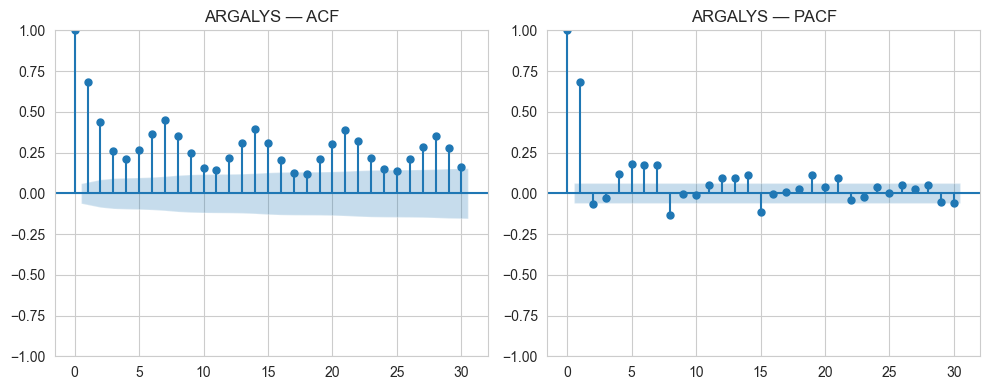

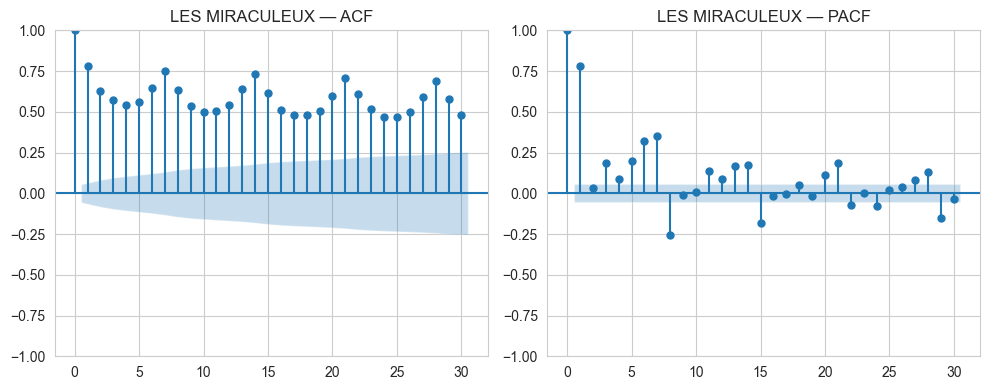

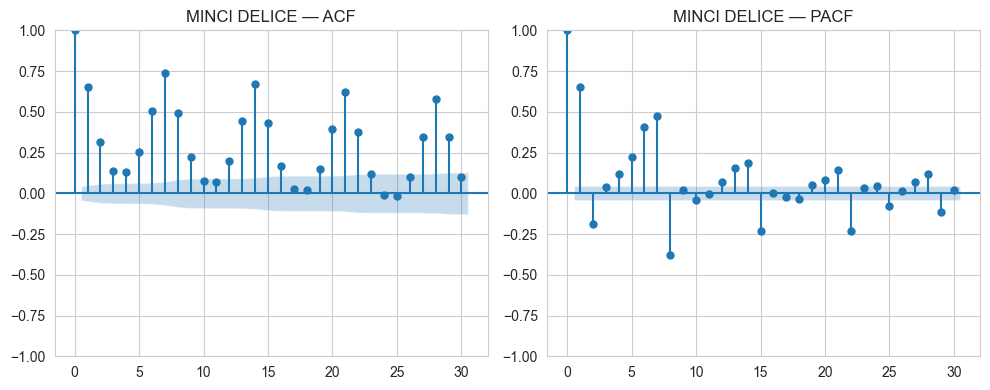

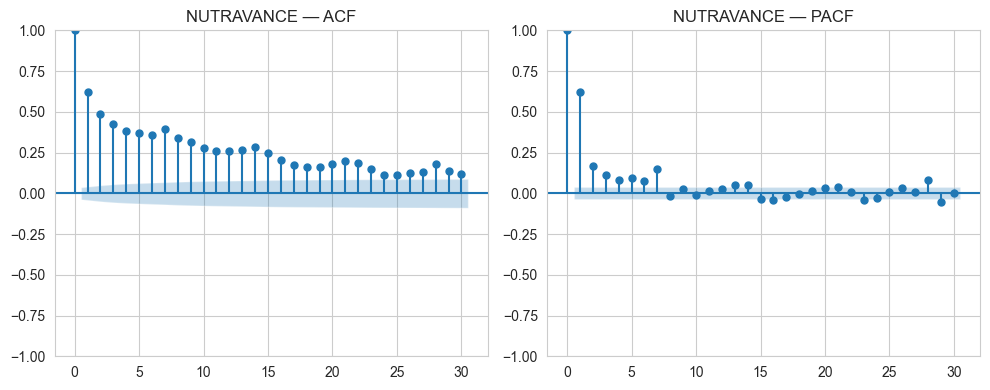

In [112]:
for cust, g in df_clean.groupby("CUSTOMER"):
    s = g.set_index("DATE").asfreq("D")["QUANTITY"].fillna(0)
    fig = plt.figure(figsize=(10,4))
    ax1 = plt.subplot(1,2,1); plot_acf(s, ax=ax1, lags=30, title=f"{cust} — ACF")
    ax2 = plt.subplot(1,2,2); plot_pacf(s, ax=ax2, lags=30, title=f"{cust} — PACF", method="ywm")
    plt.tight_layout()
    plt.show()


# ADF Test

In [120]:
def adf_test(series: pd.Series, customer_name: str, signif=0.05):
    """
    Run Augmented Dickey–Fuller test and print result.
    
    Args:
        series (pd.Series): Time series (daily frequency, numeric)
        customer_name (str): Customer label for display
        signif (float): Significance level (default=0.05)
    """
    s = series.dropna()
    if len(s) < 10:
        print(f"{customer_name}: Not enough data for ADF test.")
        return None

    result = adfuller(s, autolag='AIC')
    p_value = result[1]
    test_stat = result[0]
    crit_values = result[4]

    print(f"==== {customer_name} ====")
    print(f"ADF Statistic: {test_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    for k, v in crit_values.items():
        print(f"Critical Value {k}: {v:.4f}")

    if p_value < signif:
        print(f"Series is Stationary (reject H₀ at {signif})\n")
        return "Stationary"
    else:
        print(f"Series is Non-Stationary (fail to reject H₀)\n")
        return "Non-Stationary"

# Apply for each customer
adf_results = {}
for cust, g in df_clean.groupby("CUSTOMER"):
    s = g.set_index("DATE")["QUANTITY"].asfreq("D").fillna(0)
    status = adf_test(s, cust)
    adf_results[cust] = status

# Summary table
pd.DataFrame.from_dict(adf_results, orient='index', columns=['ADF_Stationarity'])

==== ARGALYS ====
ADF Statistic: -3.2915
p-value: 0.0153
Critical Value 1%: -3.4368
Critical Value 5%: -2.8644
Critical Value 10%: -2.5683
Series is Stationary (reject H₀ at 0.05)

==== LES MIRACULEUX ====
ADF Statistic: -2.2543
p-value: 0.1871
Critical Value 1%: -3.4356
Critical Value 5%: -2.8639
Critical Value 10%: -2.5680
Series is Non-Stationary (fail to reject H₀)

==== MINCI DELICE ====
ADF Statistic: -4.7145
p-value: 0.0001
Critical Value 1%: -3.4336
Critical Value 5%: -2.8630
Critical Value 10%: -2.5675
Series is Stationary (reject H₀ at 0.05)

==== NUTRAVANCE ====
ADF Statistic: -6.5691
p-value: 0.0000
Critical Value 1%: -3.4327
Critical Value 5%: -2.8626
Critical Value 10%: -2.5673
Series is Stationary (reject H₀ at 0.05)



,ADF_Stationarity
ARGALYS,Stationary
LES MIRACULEUX,Non-Stationary
MINCI DELICE,Stationary
NUTRAVANCE,Stationary


# **Exploratory Data Analysis (EDA) Insights Summary**

## **1. ARGALYS**

**Statistical Summary**
- Activity Period: Jul 2020 – Jun 2023 (≈ 3 years)
- Mean = 29.8 Std = 23.8 CV = 0.80 ADI = 1.00 Type = Erratic
- Continuous daily operations with low zero-ratio (≈ 0%).

**Trend & Seasonality**
- Clear growth until mid-2022, then mild stabilization.
- Additive STL fits best (RelResid 0.2171).
- Weak monthly seasonality with slight peaks in **Jan** and **May**, dips in **Jun–Aug**.
- Weekly activity peaks: **Sat–Mon** → suggests weekend dispatch or restocking.

**ACF/PACF Behavior**
- ACF decays gradually (lags ≈ 5–10 days), PACF cuts off early → short-term persistence typical of daily demand.

**Stationarity (ADF)**
- p = 0.0153 → Stationary  
  Mean and variance stable after mild detrending; no differencing required.

**Interpretation**  
Continuous but noisy daily shipments; growth stabilizing after expansion in 2021–22.  
Volatility likely reflects small order batching and short-horizon logistics.

**Modeling Implication**  
ARIMA / ETS or short-memory ML models (e.g., XGBoost with lag features) are appropriate.

**Executive Takeaway**  
Stable but noisy daily demand — warehouse entering maturity phase; suitable for short-term autoregressive forecasting.

---

## **2. LES MIRACULEUX**

**Statistical Summary**
- Activity Period: May 2019 – Jun 2023  
- Mean = 740 Std = 665 CV = 0.90 ADI = 1.00 Type = Erratic  
- High-volume continuous operations.

**Trend & Seasonality**
- Linear upward trend through 2023 → strong growth.
- Multiplicative STL best (RelResid 0.2035).
- Pronounced annual seasonality — peaks in **May & Nov**, dips in **Jul–Aug & Dec**.
- Weekly seasonality: **Sat–Mon** activity peak.

**ACF/PACF Behavior**
- ACF shows strong persistence up to 30 lags with cyclic peaks → yearly periodicity.
- PACF suggests short-lag dependence (~1–3 days).

**Stationarity (ADF)**
- p = 0.1871 → Non-stationary  
  Requires first differencing or trend removal before modeling.

**Interpretation**  
High and growing demand with strong seasonality → represents a mature, fast-moving product.  
Non-stationarity stems from continuous upward trend and evolving seasonal amplitude.

**Modeling Implication**  
Use trend + seasonal models such as **Prophet**, **SARIMA (1,1,1)(1,1,1,12)**, or gradient boosting with lag & calendar features.

**Executive Takeaway**  
Rapidly scaling, strongly seasonal demand — requires trend-aware, seasonal modeling for reliable forecasts.

---

## **3. MINCI DELICE**

**Statistical Summary**
- Activity Period: Sep 2017 – Jun 2023  
- Mean = 1952 Std = 999 CV = 0.51 ADI = 1.00 Type = Erratic  
- Continuous daily activity with moderate variability.

**Trend & Seasonality**
- Bell-shaped trend: linear growth → plateau (2019–20) → decline post-2021.
- Multiplicative STL fits best (RelResid 0.3928).
- Strong yearly seasonality: peak in **May**, trough in **Dec**.
- Weekly pattern: **Sat–Tue** active, **Wed–Fri** lighter.

**ACF/PACF Behavior**
- ACF shows periodic spikes (~7, 14, 21 days) → weekly cycle.
- PACF significant up to 4 days → short-term correlation.

**Stationarity (ADF)**
- p = 0.0001 → Stationary  
  Variance stabilized by multiplicative decomposition.

**Interpretation**  
Steady operational rhythm with clear annual and weekly patterns.  
Post-2021 decline suggests possible product lifecycle maturity or reduced promotion intensity.

**Modeling Implication**  
Multiplicative seasonality → **SARIMA**, **Prophet**, or **Holt–Winters (Multiplicative)** are suitable.

**Executive Takeaway**  
Highly seasonal yet statistically stable series — ideal for classical multiplicative seasonal models.

---

## **4. NUTRAVANCE**

**Statistical Summary**
- Activity Period: Aug 2015 – Jun 2023  
- Mean = 146.9 Std = 101.7 CV = 0.69 ADI = 1.00 Type = Erratic  
- Longest historical coverage; moderate daily volatility.

**Trend & Seasonality**
- Continuous upward trend through 2023 → steady long-term growth.
- Multiplicative STL best (RelResid 0.4153).
- Distinct annual seasonality — peaks in **Mar & Sep**, trough in **Aug**.
- Weekly cycle: **Mon–Thu** higher dispatches.

**ACF/PACF Behavior**
- ACF decays smoothly → medium-term persistence.  
- PACF significant at lags 1–2 → autoregressive component likely.

**Stationarity (ADF)**  
Stationary.

**Interpretation**  
Stable, long-term growth with consistent repeating seasonality; least noisy among smaller-volume series.

**Modeling Implication**  
Good candidate for **exponential smoothing / SARIMA** with multiplicative seasonality or ML models with calendar features.

**Executive Takeaway**  
Long-term stable growth with repeatable annual pattern — reliable series for seasonal forecasting models.

---

## **Cross-Customer Summary**

| Customer | Trend | Seasonality | ADF Stationarity | STL Type | Demand Type | Key Insight |
|-----------|--------|-------------|------------------|-----------|--------------|--------------|
| ARGALYS | Up → flat | Weak (annual + weekly) | Stationary | Additive | Erratic | Stable small-scale daily demand, moderate volatility |
| LES MIRACULEUX | Strong upward | Strong (yearly) | Non-stationary | Multiplicative | Erratic | Rapid growth + seasonality; trending |
| MINCI DELICE | Rise → fall | Strong (yearly + weekly) | Stationary | Multiplicative | Erratic | Peak 2021, steady seasonality post-decline |
| NUTRAVANCE | Continuous up | Annual cycle | Stationary | Multiplicative | Erratic | Consistent long-term growth, periodic demand |

---

## **General Observations**
1. All four customers exhibit erratic (continuous but volatile) daily demand — typical for warehouse-level time series.  
2. Seasonality patterns are predominantly annual and weekly, confirming logistic and retail restocking cycles.  
3. Three of four series are stationary, suggesting stable mean and variance after trend decomposition.  
4. Multiplicative decomposition dominates, meaning variance scales with the level → use multiplicative seasonal models.

---

## **Modeling Direction Summary**

| Characteristic | Implication |
|----------------|-------------|
| High variance but frequent activity | Focus on volatility modeling, not intermittent-demand models |
| Weekly + annual patterns | Include calendar features or harmonic seasonality |
| Mixed trend behavior | Use models combining trend + seasonality (SARIMA, Prophet, Gradient Boosting) |
| Mostly stationary after cleaning | Differencing optional; emphasize feature-based forecasting |

---

## **Overall Takeaway**

All warehouse customers display erratic yet regular daily demand with clear seasonal structure and stable residual variance.  
Forecasting should therefore target **short-term volatility capture (7–30 day horizon)** and **trend-seasonality modeling**, rather than sporadic-demand techniques.